# 02 - Data from the Web

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.toptop_universities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide top_universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
1. Obtain the 200 top-ranking top_universities in www.toptop_universities.com ([ranking 2018](https://www.toptop_universities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.toptop_universities.com/top_universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best top_universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking top_universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match top_universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.

In [26]:
import requests, re, html
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

from tqdm import tqdm_notebook

NUM_OBS = 200

# www.topuniversities.com

In [4]:
root_url_1 = 'https://www.topuniversities.com'
# we use the link to the API from where the website fetches its data instead of BeautifulSoup
# much much cleaner
list_url_1 = root_url_1 + '/sites/default/files/qs-rankings-data/357051_indicators.txt'

r = requests.get(list_url_1)
top_universities = pd.DataFrame()
top_universities = top_universities.from_dict(r.json()['data'])[['uni', 'overall_rank', 'location', 'region']]
# get the university name and details URL with a regex
top_universities['name'] = top_universities['uni'].apply(lambda name: html.unescape(re.findall('<a[^>]+href=\"(.*?)\"[^>]*>(.*)?</a>', name)[0][1]))
top_universities['url'] = top_universities['uni'].apply(lambda name: html.unescape(re.findall('<a[^>]+href=\"(.*?)\"[^>]*>(.*)?</a>', name)[0][0]))
top_universities.drop('uni', axis=1, inplace=True)
top_universities['overall_rank'] = top_universities['overall_rank'].astype(int)

top_universities.head()

,overall_rank,location,region,name,url
0,1,United States,North America,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...
1,2,United States,North America,Stanford University,/universities/stanford-university
2,3,United States,North America,Harvard University,/universities/harvard-university
3,4,United States,North America,California Institute of Technology (Caltech),/universities/california-institute-technology-...
4,5,United Kingdom,Europe,University of Cambridge,/universities/university-cambridge


In [5]:
# selects the top N rows based on the colum_name of the dataframe df 
def select_top_N(df, column_name, N):
    df = df.sort_values(by=column_name)
    df = df[df[column_name] <= N]
    return df

In [6]:
# get only the first top-200 universities by overall rank
top_universities = select_top_N(top_universities, 'overall_rank', NUM_OBS)
top_universities.head()

,overall_rank,location,region,name,url
0,1,United States,North America,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...
1,2,United States,North America,Stanford University,/universities/stanford-university
2,3,United States,North America,Harvard University,/universities/harvard-university
3,4,United States,North America,California Institute of Technology (Caltech),/universities/california-institute-technology-...
4,5,United Kingdom,Europe,University of Cambridge,/universities/university-cambridge


In [7]:
students_total = []
students_inter = []
faculty_total = []
faculty_inter = []

def get_num(soup, selector):
    scraped = soup.select(selector)
    # Some top_universities don't have stats, return NaN for these case
    if scraped:
        return int(scraped[0].contents[0].replace(',', ''))
    else:
        return np.NaN


for details_url in tqdm_notebook(top_universities['url']):
    soup = BeautifulSoup(requests.get(root_url_1 + details_url).text, 'html.parser')
    
    students_total.append(get_num(soup, 'div.total.student div.number'))
    students_inter.append(get_num(soup, 'div.total.inter div.number'))
    faculty_total.append(get_num(soup, 'div.total.faculty div.number'))
    faculty_inter.append(get_num(soup, 'div.inter.faculty div.number'))


top_universities['students_total'] = students_total
top_universities['students_international'] = students_inter
top_universities['students_national'] = top_universities['students_total'] - top_universities['students_international']
top_universities['faculty_total'] = faculty_total
top_universities['faculty_international'] = faculty_inter
top_universities['faculty_national'] = top_universities['faculty_total'] - top_universities['faculty_international']

top_universities.head()

,overall_rank,location,region,name,url,students_total,students_international,students_national,faculty_total,faculty_international,faculty_national
0,1,United States,North America,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...,11067.0,3717.0,7350.0,2982.0,1679.0,1303.0
1,2,United States,North America,Stanford University,/universities/stanford-university,15878.0,3611.0,12267.0,4285.0,2042.0,2243.0
2,3,United States,North America,Harvard University,/universities/harvard-university,22429.0,5266.0,17163.0,4350.0,1311.0,3039.0
3,4,United States,North America,California Institute of Technology (Caltech),/universities/california-institute-technology-...,2255.0,647.0,1608.0,953.0,350.0,603.0
4,5,United Kingdom,Europe,University of Cambridge,/universities/university-cambridge,18770.0,6699.0,12071.0,5490.0,2278.0,3212.0


In [8]:
#defining colors for each type of plot
colors_1 = ['#FF9F9A', '#D0BBFF']
colors_2 = ['#92C6FF', '#97F0AA']
plt.style.use('ggplot')

# Best universities in term of:

We selected the top 10 universities in point (a) and (b). For point (c) and (d), the top 200 universities were used in order to have more data.

## (a) ratio between faculty members and students

In [9]:
top = 10
top_universities_ratio = select_top_N(top_universities, 'overall_rank', top)

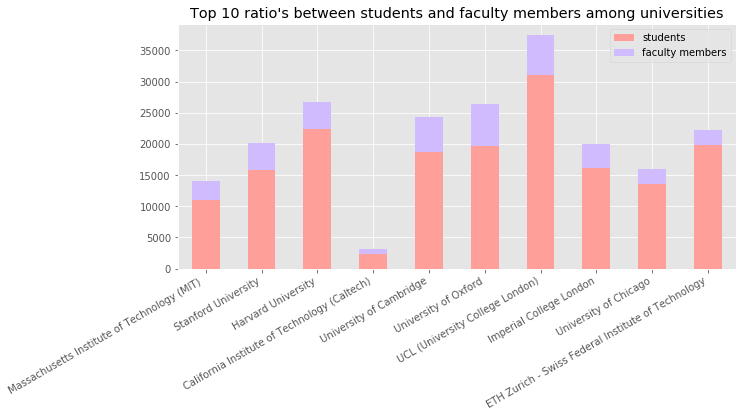

In [10]:
top_universities_ratio_sf = top_universities_ratio[['name', 'students_total', 'faculty_total']]
top_universities_ratio_sf = top_universities_ratio_sf.set_index(['name'])
top_universities_ratio_sf.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(10,5), sharey=True)
top_universities_ratio_sf.plot.bar(stacked=True, color=colors_1, ax=axes)
axes.set_title('Top 10 ratio\'s between students and faculty members among universities')
axes.legend(labels=['students', 'faculty members'])
fig.autofmt_xdate()
plt.show()

**Comments:** We see that it is rather difficult to compare the ratios of the different universities. This is due to the different sizes of the population. In order to draw more precise information about it, we need to normalize the data with repect to each university.

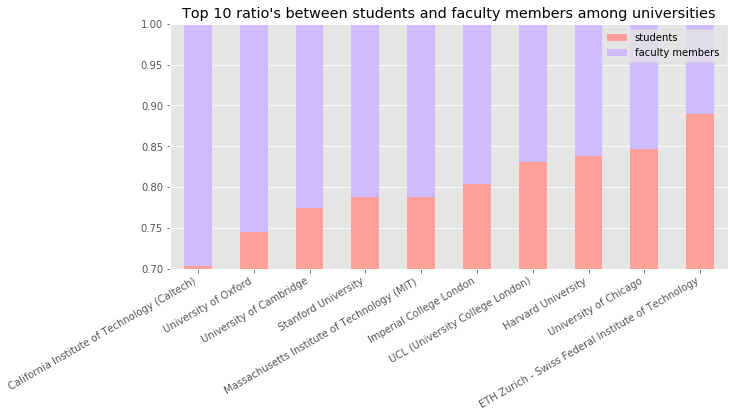

In [11]:
# normalize the data to be able to make a good comparison
top_universities_ratio_normed = top_universities_ratio_sf.div(top_universities_ratio_sf.sum(1), axis=0).sort_values(by='faculty_total', ascending=False)
top_universities_ratio_normed.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(10,5), sharey=True)
top_universities_ratio_normed.plot.bar(stacked=True, color=colors_1, ax=axes)
axes.set_title('Top 10 ratio\'s between students and faculty members among universities')
axes.legend(labels=['students', 'faculty members'])
# we can restrict the range on the y axis to avoid displaying unnecessary content
axes.set_ylim([0.7,1])
fig.autofmt_xdate()
plt.show()

**Comments**: You noticed that the y-axis ranges from 0.7 to 1. We limited the visualization to this interval because the complete interval does not add meaningful insight about the data. Analyzing the results, we see that the Caltech university is the university in the top 10 offering more faculty members to its students. ETHZ is in the last position.

## (b) ratio of international students

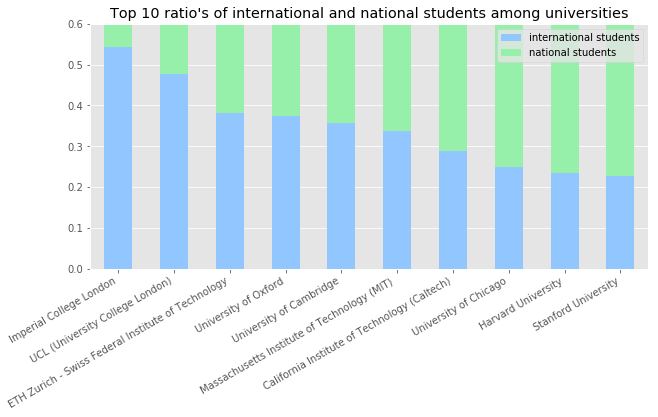

In [12]:
top_universities_ratio_s = top_universities_ratio[['name', 'students_international', 'students_national']]
top_universities_ratio_s = top_universities_ratio_s.set_index(['name'])
top_universities_ratio_s_normed = top_universities_ratio_s.div(top_universities_ratio_s.sum(1), axis=0).sort_values(by='students_international', ascending=False)
top_universities_ratio_s_normed.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
top_universities_ratio_s_normed.plot.bar(stacked=True, color=colors_2, ax=axes)
axes.set_title('Top 10 ratio\'s of international and national students among universities')
axes.legend(labels=['international students', 'national students'])
axes.set_ylim([0, 0.6])
fig.autofmt_xdate()
plt.show()

**Comments**: The most international university, by its students, among the top 10 universities is the Imperial College London. Notice that ETHZ is in the third position.

## (c) same comparisons by country

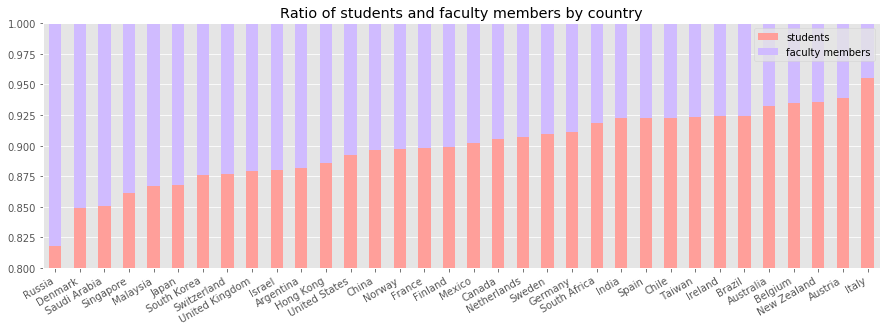

In [13]:
ratio_country_sf = top_universities.groupby(['location'])['students_total', 'faculty_total'].sum()
ratio_country_sf_normed = ratio_country_sf.div(ratio_country_sf.sum(1), axis=0).sort_values(by='faculty_total', ascending=False)
ratio_country_sf_normed.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
ratio_country_sf_normed.plot.bar(stacked=True, color=colors_1, ax=axes)
axes.set_title('Ratio of students and faculty members by country')
axes.legend(labels=['students', 'faculty members'])
axes.set_ylim([0.8,1])
fig.autofmt_xdate()
plt.show()

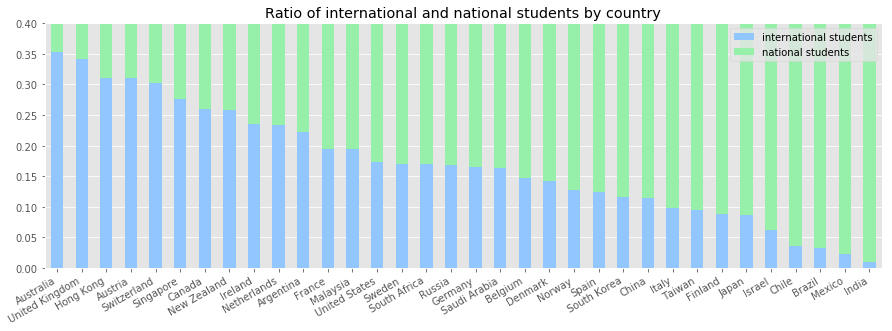

In [14]:
ratio_country_s = top_universities.groupby(['location'])['students_international', 'students_national'].sum()
ratio_country_s_normed = ratio_country_s.div(ratio_country_s.sum(1), axis=0).sort_values(by='students_international', ascending=False)
ratio_country_s_normed.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
ratio_country_s_normed.plot.bar(stacked=True, color=colors_2, ax=axes)
axes.set_title('Ratio of international and national students by country')
axes.legend(labels=['international students', 'national students'])
axes.set_ylim([0, 0.4])
fig.autofmt_xdate()
plt.show()

**Comments**: Aggregating the data by country, we see that Russia is the country offering more faculty members for its student, followed by Danemark and Saudi Arabia. The most international university in terms of students is Australia, followed by United Kingdom and Hong Kong. Switzerland is in the fourth position and India is the country with the lowest ratio of international students.  

## (d) same comparisons by region

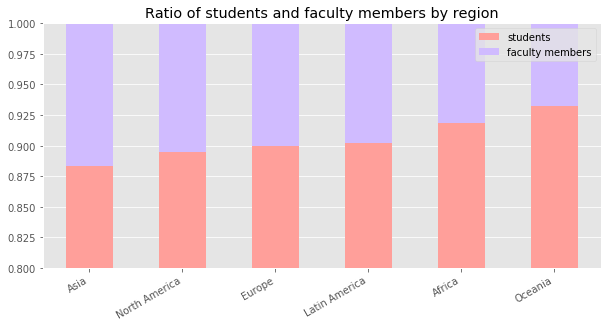

In [15]:
ratio_region_s = top_universities.groupby(['region'])['students_total', 'faculty_total'].sum()
ratio_region_s_normed = ratio_region_s.div(ratio_region_s.sum(1), axis=0).sort_values(by='faculty_total', ascending=False)
ratio_region_s_normed.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(10,5), sharey=True)
ratio_region_s_normed.plot.bar(stacked=True, color=colors_1, ax=axes)
axes.set_title('Ratio of students and faculty members by region')
axes.legend(labels=['students', 'faculty members'])
axes.set_ylim([0.8,1])
axes.yaxis.grid(True)
fig.autofmt_xdate()
plt.show()

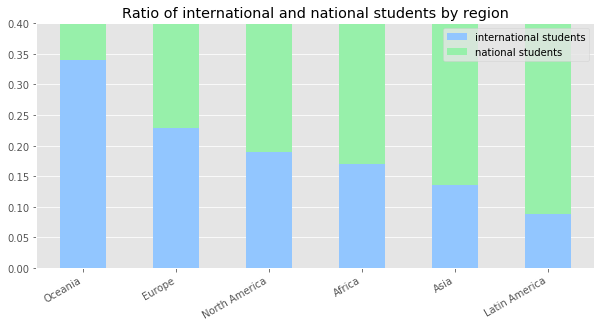

In [16]:
ratio_region_s = top_universities.groupby(['region'])['students_international', 'students_national'].sum()
ratio_region_s_normed = ratio_region_s.div(ratio_region_s.sum(1), axis=0).sort_values(by='students_international', ascending=False)
ratio_region_s_normed.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(10,5), sharey=True)
ratio_region_s_normed.plot.bar(stacked=True, color=colors_2, ax=axes)
axes.set_title('Ratio of international and national students by region')
axes.legend(labels=['international students', 'national students'])
axes.set_ylim([0,0.4])
axes.yaxis.grid(True)
fig.autofmt_xdate()
plt.show()

**Comments:** Asia is the region offering more faculty members to its students. It is followed by North America and Europe. The most international university in terms of students is Oceania. Europe is second.

### Analysis of the two methods

We get consistent results comparing the results obtained by region or by country about the ratio of international students. By country, we get Australia and by region, Oceania. This makes sense as Australia owns nine of the eleven top_universities of Oceania. 

# www.timeshighereducation.com

In [86]:
# we repeat the same procedure as for www.topuniversities.com
root_url_2 = 'https://www.timeshighereducation.com'
list_url_2 = root_url_2 + '/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

r = requests.get(list_url_2)
times_higher_education = pd.DataFrame()
times_higher_education = times_higher_education.from_dict(r.json()['data'])[['rank', 'location', 'location', 'name', 'url', 'stats_number_students', 'stats_pc_intl_students', 'stats_student_staff_ratio']]

# rename columns as is the first dataframe
times_higher_education.columns = ['overall_rank', 'location', 'region', 'name', 'url', 'students_total', 'ratio_inter', 'student_staff_ratio']


# as the ranks have different represetation we had to delete the '=' in front of universities that have the same rank,
# rewrite the rank when it is represented as an interval (ex: 201-250) and finally delete the '+' in the end for the last ones 
times_higher_education['overall_rank'] = times_higher_education['overall_rank'].apply(lambda rank: re.sub('[=]', '', rank))
times_higher_education['overall_rank'] = times_higher_education['overall_rank'].apply(lambda rank: rank.split('–')[0])
times_higher_education['overall_rank'] = times_higher_education['overall_rank'].apply(lambda rank: re.sub('[+]', '', rank)).astype(int)

# remaps a ranking in order to make selection by ranking easier
# ex: 1,2,3,3,5,6,7 -> 1,2,3,3,4,5,6
def remap_ranking(rank):
    last=0
    for i in range(len(rank)):
        if last == rank[i]-1:
            #no problem
            last = rank[i]
        elif last != rank[i]:
            last = last+1
            rank[i] = last
            rank[(i+1):] = rank[(i+1):]-1
    return rank

times_higher_education['overall_rank'] = remap_ranking(times_higher_education['overall_rank'].copy())


# in the following lines we make the necessary transformation in order to get the right type or numbers for each column
times_higher_education['students_total'] = times_higher_education['students_total'].apply(lambda x: re.sub('[^0-9]','', x)).astype(int) 
times_higher_education['ratio_inter'] = times_higher_education['ratio_inter'].apply(lambda x: re.sub('[^0-9]','', x)).astype(float) 
times_higher_education['student_staff_ratio'] = times_higher_education['student_staff_ratio'].astype(float) 

times_higher_education['students_international'] = (times_higher_education['students_total'] * (times_higher_education['ratio_inter']/100)).astype(int)
times_higher_education['students_national'] = times_higher_education['students_total'] - times_higher_education['students_international']

times_higher_education['faculty_total'] = (times_higher_education['students_total'] / times_higher_education['student_staff_ratio']).astype(int)
times_higher_education['faculty_international'] = 'N/A'
times_higher_education['faculty_national'] = 'N/A' 

times_higher_education['region'] = 'N/A'

# resolve ties
times_higher_education['overall_rank'] = np.arange(1, times_higher_education.shape[0]+1)


# resolve N/A region
loc_to_reg = top_universities[['location', 'region']]
loc_to_reg = set(loc_to_reg.apply(lambda x: '{}_{}'.format(x['location'], x['region']), axis=1).values)
loc_to_reg = {x.split('_')[0]: x.split('_')[1] for x in loc_to_reg}
from collections import defaultdict
loc_to_reg = defaultdict(lambda: 'N/A', loc_to_reg)
def resolve_uni(x):
    x['region'] = loc_to_reg[x['location']]
    return x

#times_higher_education = times_higher_education.apply(resolve_uni, axis=1)

print(times_higher_education['region'].unique())



del times_higher_education['ratio_inter']
del times_higher_education['student_staff_ratio']


N/A
N/A
N/A
N/A
N/A
['N/A']


In [81]:
# get only the first top-200 universities by overall rank
times_higher_education = select_top_N(times_higher_education, 'overall_rank', NUM_OBS)
times_higher_education.head()

,overall_rank,location,region,name,url,students_total,students_international,students_national,faculty_total,faculty_international,faculty_national
0,1,United Kingdom,Europe,University of Oxford,/world-university-rankings/university-oxford,20409,7755,12654,1822,N/A,N/A
1,2,United Kingdom,Europe,University of Cambridge,/world-university-rankings/university-cambridge,18389,6436,11953,1687,N/A,N/A
2,3,United States,North America,California Institute of Technology,/world-university-rankings/california-institut...,2209,596,1613,339,N/A,N/A
3,4,United States,North America,Stanford University,/world-university-rankings/stanford-university,15845,3485,12360,2112,N/A,N/A
4,5,United States,North America,Massachusetts Institute of Technology,/world-university-rankings/massachusetts-insti...,11177,3800,7377,1284,N/A,N/A


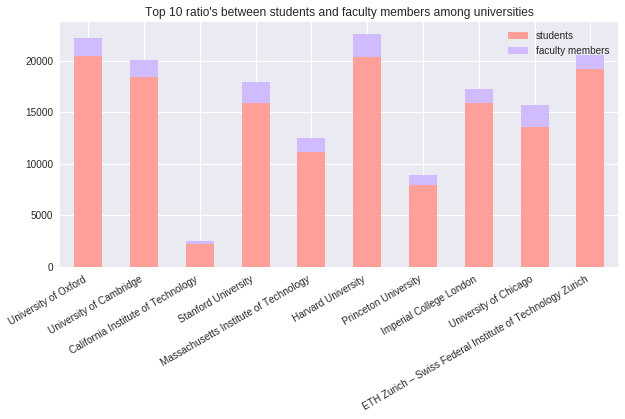

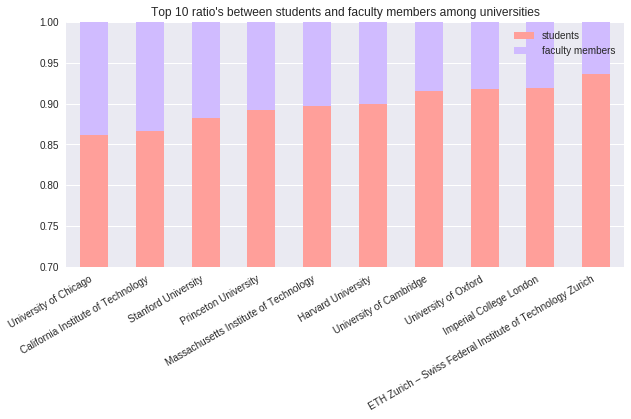

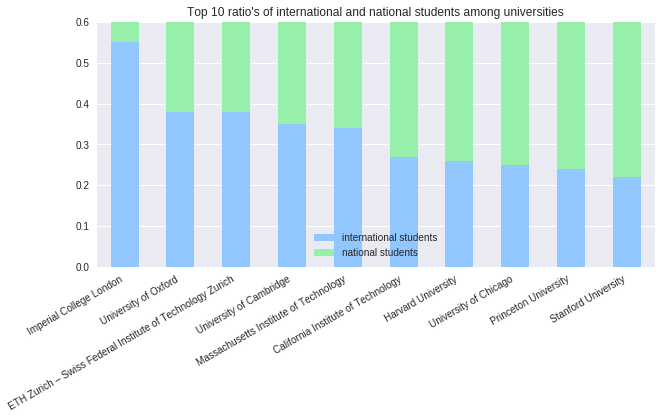

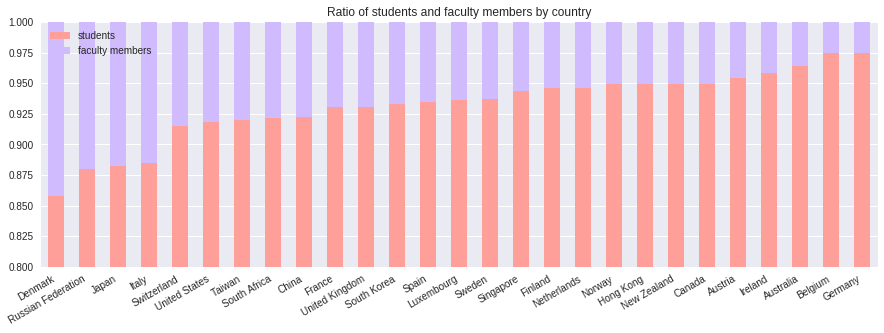

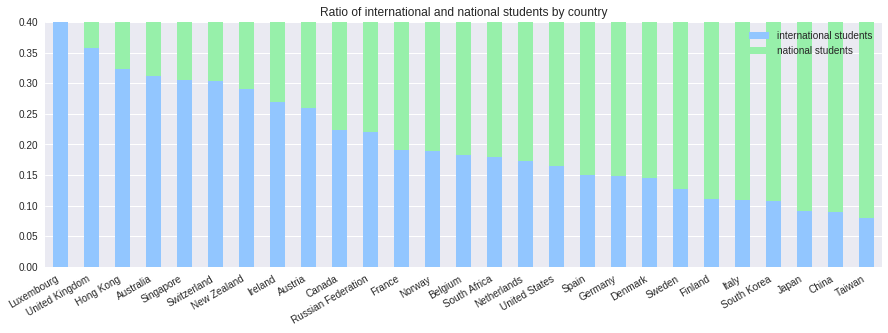

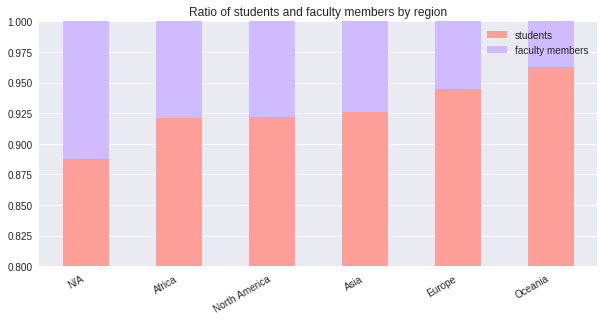

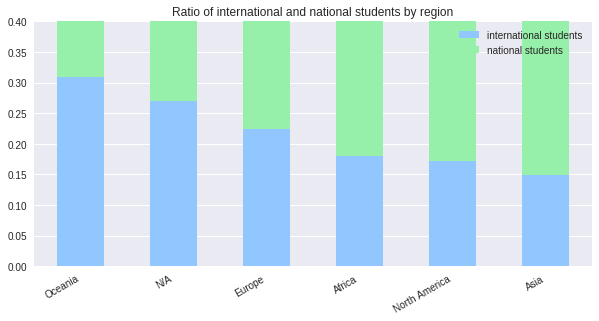

In [82]:
top = 10
times_higher_education_ratio = select_top_N(times_higher_education, 'overall_rank', top)


times_higher_education_ratio_sf = times_higher_education_ratio[['name', 'students_total', 'faculty_total']]
times_higher_education_ratio_sf = times_higher_education_ratio_sf.set_index(['name'])
times_higher_education_ratio_sf.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(10,5), sharey=True)
times_higher_education_ratio_sf.plot.bar(stacked=True, color=colors_1, ax=axes)
axes.set_title('Top 10 ratio\'s between students and faculty members among universities')
axes.legend(labels=['students', 'faculty members'])
fig.autofmt_xdate()
plt.show()




# normalize the data to be able to make a good comparison
times_higher_education_ratio_normed = times_higher_education_ratio_sf.div(times_higher_education_ratio_sf.sum(1), axis=0).sort_values(by='faculty_total', ascending=False)
times_higher_education_ratio_normed.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(10,5), sharey=True)
times_higher_education_ratio_normed.plot.bar(stacked=True, color=colors_1, ax=axes)
axes.set_title('Top 10 ratio\'s between students and faculty members among universities')
axes.legend(labels=['students', 'faculty members'])
# we can restrict the range on the y axis to avoid displaying unnecessary content
axes.set_ylim([0.7,1])
fig.autofmt_xdate()
plt.show()





times_higher_education_ratio_s = times_higher_education_ratio[['name', 'students_international', 'students_national']]
times_higher_education_ratio_s = times_higher_education_ratio_s.set_index(['name'])
times_higher_education_ratio_s_normed = times_higher_education_ratio_s.div(times_higher_education_ratio_s.sum(1), axis=0).sort_values(by='students_international', ascending=False)
times_higher_education_ratio_s_normed.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
times_higher_education_ratio_s_normed.plot.bar(stacked=True, color=colors_2, ax=axes)
axes.set_title('Top 10 ratio\'s of international and national students among universities')
axes.legend(labels=['international students', 'national students'])
axes.set_ylim([0, 0.6])
fig.autofmt_xdate()
plt.show()





ratio_country_sf = times_higher_education.groupby(['location'])['students_total', 'faculty_total'].sum()
ratio_country_sf_normed = ratio_country_sf.div(ratio_country_sf.sum(1), axis=0).sort_values(by='faculty_total', ascending=False)
ratio_country_sf_normed.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
ratio_country_sf_normed.plot.bar(stacked=True, color=colors_1, ax=axes)
axes.set_title('Ratio of students and faculty members by country')
axes.legend(labels=['students', 'faculty members'])
axes.set_ylim([0.8,1])
fig.autofmt_xdate()
plt.show()





ratio_country_s = times_higher_education.groupby(['location'])['students_international', 'students_national'].sum()
ratio_country_s_normed = ratio_country_s.div(ratio_country_s.sum(1), axis=0).sort_values(by='students_international', ascending=False)
ratio_country_s_normed.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
ratio_country_s_normed.plot.bar(stacked=True, color=colors_2, ax=axes)
axes.set_title('Ratio of international and national students by country')
axes.legend(labels=['international students', 'national students'])
axes.set_ylim([0, 0.4])
fig.autofmt_xdate()
plt.show()





ratio_region_s = times_higher_education.groupby(['region'])['students_total', 'faculty_total'].sum()
ratio_region_s_normed = ratio_region_s.div(ratio_region_s.sum(1), axis=0).sort_values(by='faculty_total', ascending=False)
ratio_region_s_normed.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(10,5), sharey=True)
ratio_region_s_normed.plot.bar(stacked=True, color=colors_1, ax=axes)
axes.set_title('Ratio of students and faculty members by region')
axes.legend(labels=['students', 'faculty members'])
axes.set_ylim([0.8,1])
axes.yaxis.grid(True)
fig.autofmt_xdate()
plt.show()





ratio_region_s = times_higher_education.groupby(['region'])['students_international', 'students_national'].sum()
ratio_region_s_normed = ratio_region_s.div(ratio_region_s.sum(1), axis=0).sort_values(by='students_international', ascending=False)
ratio_region_s_normed.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(10,5), sharey=True)
ratio_region_s_normed.plot.bar(stacked=True, color=colors_2, ax=axes)
axes.set_title('Ratio of international and national students by region')
axes.legend(labels=['international students', 'national students'])
axes.set_ylim([0,0.4])
axes.yaxis.grid(True)
fig.autofmt_xdate()
plt.show()

In [83]:
# Try to detect same universities with different name in the two dataframe before merging
# Using Jaccard similarity and same location rule (seems to keep matching entry)
def t(x):
    # Compute Jaccard score (intersection over union)
    def jaccard(a, b):
        u = set(a.split(' '))
        v = set(b.split(' '))
        return len(u.intersection(v)) / len(u.union(v))
        
    names = top_universities['name'].tolist()
    locations = top_universities['location'].tolist()
    scores = np.array([jaccard(x['name'], n) for n in names])
    m = scores.max()
    i = scores.argmax()
    # Jaccard score for similarity and location match to filter out  name with different location
    if m > 0.5 and x['location'] == locations[i]:
        #print(x['name'], '-->', names[i], m)
        #print(x['location'], '|'  ,locations[i])
        #print('-----')
        x['name'] = names[i]
    return x
    
# Try to match universities name in both dataframe    
times_higher_education = times_higher_education.apply(t, axis=1)
# Keep intersection on the name column of the two datasets 
merged = pd.merge(top_universities, times_higher_education, on='name', how='inner')

print(merged.shape)
merged.head()

(145, 21)


,overall_rank_x,location_x,region_x,name,url_x,students_total_x,students_international_x,students_national_x,faculty_total_x,faculty_international_x,...,overall_rank_y,location_y,region_y,url_y,students_total_y,students_international_y,students_national_y,faculty_total_y,faculty_international_y,faculty_national_y
0,1,United States,North America,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...,11067.0,3717.0,7350.0,2982.0,1679.0,...,5,United States,North America,/world-university-rankings/massachusetts-insti...,11177,3800,7377,1284,N/A,N/A
1,2,United States,North America,Stanford University,/universities/stanford-university,15878.0,3611.0,12267.0,4285.0,2042.0,...,4,United States,North America,/world-university-rankings/stanford-university,15845,3485,12360,2112,N/A,N/A
2,3,United States,North America,Harvard University,/universities/harvard-university,22429.0,5266.0,17163.0,4350.0,1311.0,...,6,United States,North America,/world-university-rankings/harvard-university,20326,5284,15042,2283,N/A,N/A
3,4,United States,North America,California Institute of Technology (Caltech),/universities/california-institute-technology-...,2255.0,647.0,1608.0,953.0,350.0,...,3,United States,North America,/world-university-rankings/california-institut...,2209,596,1613,339,N/A,N/A
4,5,United Kingdom,Europe,University of Cambridge,/universities/university-cambridge,18770.0,6699.0,12071.0,5490.0,2278.0,...,2,United Kingdom,Europe,/world-university-rankings/university-cambridge,18389,6436,11953,1687,N/A,N/A


# Insights
Here we first proceed by creating the correlation matrix (since it's a symetric matrix we only kepts the lower triangle). We then plot it using a heatmap to see correlation between columns of the dataframe. We also made another heatmap with only correlation whose absolute value is greater than 0.5. Finally we averaged the features when they were available for the two websites (except rankings).

## Correlations analysis
Some correlations bring interesting information:
- $Corr(overall\_rank\_x, overall\_rank\_y) = 0.7$ <br />
We a strong correlation between the ranking of the first website and the second one. It shows us that the two webstite ranking method leads on similar results (since the correlation is positive). It's insightfull since even if the features are approximately the same for the two websites, their methodology to attribute a rank could be really different. This important positive correlation reveals that the methodologies doesn't differ so much between the two websites.
- $Corr(students\_international\_avg, faculty\_international\_avg) = 0.59$ <br />
Here we have an interesting correlation between the number of international students and the number of international staff members.
- We have strong correlation between same features but coming from different websites. It's not really interesting since difference in same features from the two websites are likely to be small. Also we have important correlation between "total" features and their sub-categories like "international" and "national". These are not interesting too because they follow a simple relation: when the total is higher, the sub-categories are likely to be higher numbers too (i.e. if the we have more students, we are likely to have more national or international students)

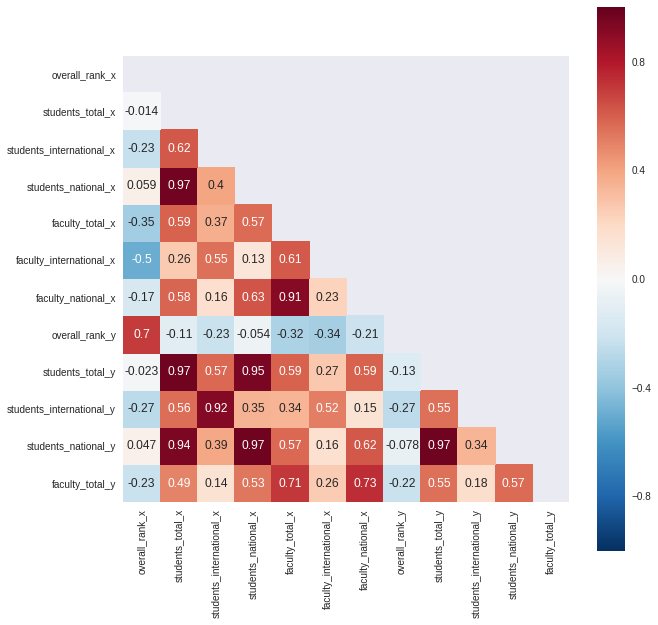

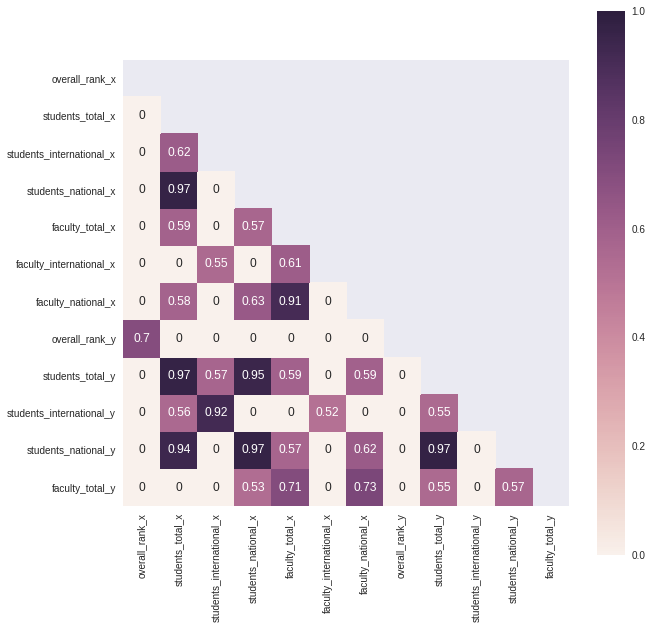

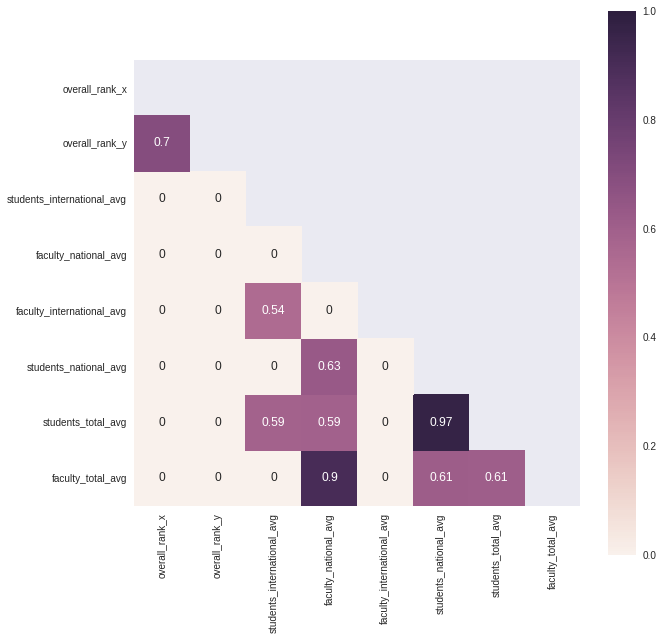

In [71]:
merged_num = merged.select_dtypes(include=[np.number])
merged_num.dropna(how='all', axis=1)
merged_num.dropna(how='any', axis=0)

def avg_feature(x):
    cols = set([x for x in x.index if 'overall' not in x])
    cols_common = set([x[0:-2] for x in cols])
    for cc in cols_common:
        cc_x = '{}_x'.format(cc)
        cc_y = '{}_y'.format(cc)
        if cc_y in cols:
            x['{}_avg'.format(cc)] = (x[cc_x] + x[cc_y]) / 2
        else:
            x['{}_avg'.format(cc)] = x[cc_x] / 2
    for c in cols:
        del x[c]
    return x
    
merged_num_avg = merged_num.apply(avg_feature, axis=1)





merged_num.head()
corr = merged_num.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, ax=ax, mask=mask, annot=True, square=True)
plt.show()

# Keep only correlation with and absolute value superior to 0.5 
corr[(corr < 0.5) & (corr > -0.5)] = 0
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, ax=ax, mask=mask, annot=True, square=True)
plt.show()

# Keep only correlation with and absolute value superior to 0.5 for averaged features
corr = merged_num_avg.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
corr[(corr < 0.5) & (corr > -0.5)] = 0
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, ax=ax, mask=mask, annot=True, square=True)
plt.show()

# Best university

First we have to transform ranking in some score. Here we assume a linear relation for the score given the ranking,
so we gave a score of 1 for the best ranking and 0 for the worst ranking with linear mapping between these two. We did it for each of the ranking (the two websites).
Also we don't really know if a website is most trustworthy than the other, so a good merging for the ranking would be to take the average of the two scores with equal weights for each score.
Finally we also took into account the ration of staff member per students: <br />
$finalScore = mean(score1, score2, staff per studiants)$ <br />
After computing these values, we found that Caltech is the best university (according to our assumptions)
Per Website ranking: <br />
Caltech: top_universities -> 4 | website2 -> 3 | staff per student ration -> 0.15  => final score: 0.71

In [72]:
r = merged[['name', 'overall_rank_x', 'overall_rank_y']]
r.head()

def lin(df):
    best_rank = df.min() 
    worst_rank = df.max() 
    a = 1 / (best_rank - worst_rank)
    b = 1 - a*best_rank
    return df.apply(lambda x: a*x + b)

r['stud_staff_ratio'] = merged[['faculty_international_x', 'faculty_international_y']].mean(axis=1) / \
                        merged[['students_total_x', 'students_total_y']].mean(axis=1)
r['score_x'] = lin(r['overall_rank_x'])
r['score_y'] = lin(r['overall_rank_y'])
r['overall_score'] = r[['score_x', 'score_y', 'stud_staff_ratio']].mean(axis=1) 
r = r.dropna()

r[r['overall_score'] == r['overall_score'].max()]

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,name,overall_rank_x,overall_rank_y,stud_staff_ratio,score_x,score_y,overall_score
3,California Institute of Technology (Caltech),4,3,0.15681,0.984925,0.98995,0.710561
